In [9]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
df = pd.read_csv("IMDB Dataset.csv", error_bad_lines = False, engine = "python")
df.dropna()

<ipython-input-10-9e35bbe74d0a>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("IMDB Dataset.csv", error_bad_lines = False, engine = "python")
Skipping line 6272: unexpected end of data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
6265,Why on earth does five US keep repeating this ...,negative
6266,"I may be getting ahead of myself here, but alt...",positive
6267,I don't know why critics cal it bizarre and ma...,positive
6268,Why was this movie made? Are producers so easi...,negative


In [11]:
df.sentiment.value_counts()

negative    3159
positive    3111
Name: sentiment, dtype: int64

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string
    # in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string
    # in BAD_SYMBOLS_RE with nothing.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    # remove stopwors from text
    return text

In [13]:
df["review"] = df['review'].apply(clean_text)

In [14]:
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [15]:
!pip install keras
!pip install tensorflow
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences

In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56150 unique tokens.


In [17]:
X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6270, 250)


In [18]:
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6270, 2)


In [33]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

In [20]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
80/80 [==============================] - 90s 1s/step - loss: 0.6111 - accuracy: 0.6906 - val_loss: 0.4250 - val_accuracy: 0.8053
Epoch 2/5
80/80 [==============================] - 61s 760ms/step - loss: 0.2433 - accuracy: 0.9090 - val_loss: 0.3955 - val_accuracy: 0.8372
Epoch 3/5
80/80 [==============================] - 62s 764ms/step - loss: 0.0593 - accuracy: 0.9829 - val_loss: 0.4395 - val_accuracy: 0.8336
Epoch 4/5
80/80 [==============================] - 61s 758ms/step - loss: 0.0136 - accuracy: 0.9976 - val_loss: 0.5535 - val_accuracy: 0.8301
Epoch 5/5
80/80 [==============================] - 62s 777ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.7024 - val_accuracy: 0.8336


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 1s 70ms/step - loss: 0.7070 - accuracy: 0.8389
Test set
  Loss: 0.707
  Accuracy: 0.839


In [22]:
import matplotlib.pyplot as plt

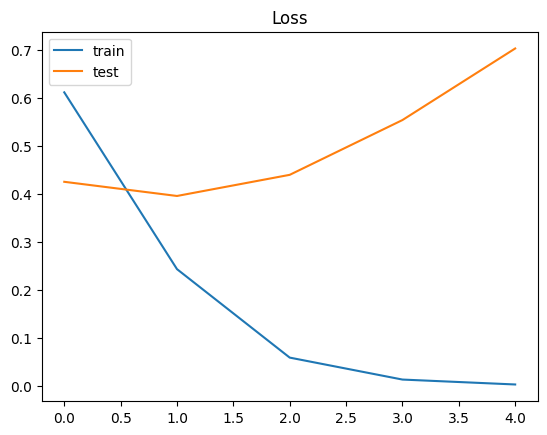

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

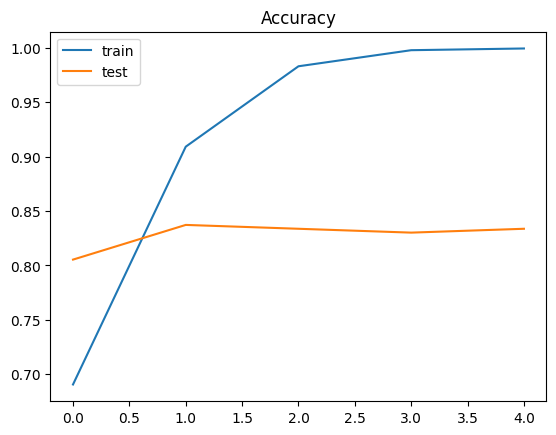

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();